In [128]:
library(readr)
library(dplyr)
library(tidyr)
library(stringr)
library(doMC)
library(lfe)
library(ggplot2)
library(ggsci)
library(xgboost)
library(lubridate)
registerDoMC(4)


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




In [159]:
fp  <- '/pool001/mfzhao/'
cp  <- read_csv(str_c(fp, 'policy/county_policy_long.csv'))
df  <- read_rds(str_c(fp, 'PROCESSED_DATA/panel_pre_xgr.RDS'))
WM  <- read_rds(str_c(fp, 'PROCESSED_DATA/stateWM.RDS'))

Parsed with column specification:
cols(
  fips = col_double(),
  name = col_character(),
  state_abbv = col_character(),
  type = col_character(),
  dt = col_date(format = "")
)



In [160]:
cp %>%
    spread(key = type, value = dt) %>%
    rowwise() %>%
    mutate(p1date = min(gatherings50, gatherings500, gyms_movies, schools, na.rm = T),
           p2date = stay_home,
           key = str_pad(fips, 5 , pad = '0')) %>%
    select(key, p1date, p2date) -> cp

In [161]:
df %>%
    left_join(cp) %>%
    mutate(p1alt = as.numeric(date - p1date > 0),
           p2alt = ifelse(is.na(p2date), 0, as.numeric(date - p2date > 0))) %>%
    filter(date < as.Date('2020-04-20')) -> df

Joining, by = "key"



In [162]:
weightedAlters <- function(df, wm, ...) {
    df %>% 
        select(date, key, ...) %>%
        spread(key = key, value = ...) %>%
        ungroup() %>%
        select(-date) %>%
        as.matrix() -> txn_data

    df %>%
        ungroup() %>%
        select(date) %>%
        distinct() %>%
        arrange(date) -> dates
    
    outMatrix <- tcrossprod(txn_data, wm)
    colnames(outMatrix) <- colnames(txn_data)
    
    data.frame(dates, outMatrix) %>%
        gather(key = 'key', value = 'value', -date) %>%
        arrange(date, key) %>%
        select(-date, -key) -> out_df
    return(out_df$value)
}

In [163]:
df %>%
    select(p1alt, p2alt) %>%
    colnames() -> cols_to_alterize
cols_to_alterize

[1] "p1alt" "p2alt"

In [164]:
stalters <- foreach(i = 1:length(cols_to_alterize), .combine = cbind) %dopar% 
    weightedAlters(df, WM, cols_to_alterize[i])
colnames(stalters) <- str_c('stalter_', cols_to_alterize)

In [165]:
df %>%
    bind_cols(as.data.frame(stalters)) -> df

In [166]:
set.seed(2345)
df %>%
    ungroup() %>%
    select(key) %>%
    distinct() %>% 
    mutate(i = sample(1:n(), n(), replace = F),
           fold = i %% 3 + 1) %>%
    select(-i) -> folds

df %>%
    inner_join(folds) %>%
    arrange(date, key) %>%
    ungroup() -> df

df %>%
    ungroup() %>%
    mutate(PRCP.r_fe = felm(PRCP ~ 0 | key + date, ., weights = df$n)$resid,
           TMAX.r_fe = felm(TMAX ~ 0 | key + date, ., weights = df$n)$resid) %>%
    select(date, key, PRCP.r_fe, TMAX.r_fe, fold, n) -> rdf

folds <- list(which(folds$fold %in% 1), 
              which(folds$fold %in% 2), 
              which(folds$fold %in% 3))

Joining, by = "key"



In [167]:
XGresidualizer <- function(Y, colname) {
    print(colname)
    rdf %>%
        ungroup() %>% 
        mutate(Y = Y,
               Y.r = felm(Y ~ 0 | key + date, ., weights = rdf$n)$resid) -> temp_df
  
    folds <- list(which(temp_df$fold %in% 1), 
                  which(temp_df$fold %in% 2), 
                  which(temp_df$fold %in% 3))

    dm    <- xgb.DMatrix(data = model.matrix(~ 0 + PRCP.r_fe + TMAX.r_fe, temp_df), label = temp_df$Y.r)
    param <- list(max_depth=2, eta=.5, silent=1, objective='reg:linear')
    fit   <- xgb.cv(params = param, 
                    data = dm, 
                    folds = folds,
                    nrounds = 100, 
                    early_stopping_rounds = 3, 
                    weight = temp_df$n)
    best_n <- fit$best_iteration
    for (i in 1:3) {
        tr  <- temp_df %>% filter(fold != i)
        trm <- xgb.DMatrix(data = model.matrix(~ 0 + PRCP.r_fe + TMAX.r_fe, tr), label = tr$Y.r)
        fit <- xgb.train(params = param, 
                         data = trm, 
                         nrounds = best_n, 
                         weight = tr$n)
        te  <- temp_df %>% filter(fold == i)
        tem <- xgb.DMatrix(data = model.matrix(~ 0 + PRCP.r_fe + TMAX.r_fe, te), label = te$Y.r)
        te %>%
            select(date, key) %>%
            mutate(pred = predict(fit, newdata = tem)) -> pred_df
        assign(str_c('temp',i), pred_df) %>%
        select(-pred, -date, -key)
    }
    out <- bind_rows(temp1, temp2, temp3) %>%
        arrange(date, key) %>%
        mutate(tempname = temp_df$Y.r - pred) %>%
        select(-pred, -date, -key)
    
    colnames(out) <- str_c(colname, '.r')
    return(out)
}

In [169]:
cols_to_xgr <- colnames(
    df %>%
        select(
            log_mcbgv, 
            log_pgt2kmt, 
            log_pgt1hafh, 
            log_pnchd, 
            p1sdp,
            p2shp,
            stalter_p1sdp,
            stalter_p2shp,
            p1alt,
            p2alt,
            stalter_p1alt,
            stalter_p2alt
        )
)

foreach(i = 1:length(cols_to_xgr), .combine = cbind) %do% 
    XGresidualizer(df[[cols_to_xgr[i]]], cols_to_xgr[i]) -> xg.residuals

df %>%
    select(date, key, n, cluster) %>%
    bind_cols(xg.residuals) -> df.r

[1] "log_mcbgv"
[1]	train-rmse:0.257114+0.000080	test-rmse:0.257117+0.000146 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 3 rounds.

[2]	train-rmse:0.138424+0.000143	test-rmse:0.138427+0.000277 
[3]	train-rmse:0.086076+0.000221	test-rmse:0.086105+0.000424 
[4]	train-rmse:0.066766+0.000284	test-rmse:0.066801+0.000573 
[5]	train-rmse:0.060939+0.000310	test-rmse:0.060990+0.000623 
[6]	train-rmse:0.059340+0.000312	test-rmse:0.059396+0.000657 
[7]	train-rmse:0.058895+0.000312	test-rmse:0.058955+0.000659 
[8]	train-rmse:0.058764+0.000312	test-rmse:0.058832+0.000658 
[9]	train-rmse:0.058698+0.000317	test-rmse:0.058768+0.000660 
[10]	train-rmse:0.058674+0.000315	test-rmse:0.058747+0.000658 
[11]	train-rmse:0.058660+0.000316	test-rmse:0.058734+0.000654 
[12]	train-rmse:0.058648+0.000315	test-rmse:0.058728+0.000655 
[13]	train-rmse:0.058633+0.000307	test-rmse:0.058715+0.000659 
[14]	train-rmse:0.058623+0.000311	test-rmse

In [170]:
df %>%
    select(date, key, n, cluster) %>%
    bind_cols(xg.residuals) -> df.r

In [171]:
ldvs <- c('log_mcbgv.r', 'log_pgt2kmt.r', 'log_pgt1hafh.r', 'log_pnchd.r')
f1 <- ' p1sdp.r + p2shp.r '  
f2 <- ' p1sdp.r + p2shp.r + stalter_p1sdp.r + stalter_p2shp.r '
f3 <- ' p1alt.r + p2alt.r '
f4 <- ' p1alt.r + p2alt.r + stalter_p1alt.r + stalter_p2alt.r '

In [172]:
get_coefs <- function(dv, vars, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | 0 | cluster')
    form <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df.r, weights = df.r$n, ...)
    
    as.data.frame(summary(model)$coef) %>%
        mutate(var   = rownames(.),
               dv    = dv,
               model = ifelse(vars == f1 | vars == f3, 'base', 'ap')) %>%
        filter(!str_detect(var, '[pPtT][rRmM][cCaA][pPxX]')) %>%
        select(7, 6, 5, 1, 2, 3, 4) -> out
    
    colnames(out) <- c('model', 'dv', 'var', 'estimate', 'se', 't', 'p-val')
    return(out)
}

In [173]:
foreach(dv = ldvs, .combine = rbind) %:% 
    foreach(f = c(f1, f2, f3, f4), .combine = rbind) %dopar%
    get_coefs(dv, f) -> coefs

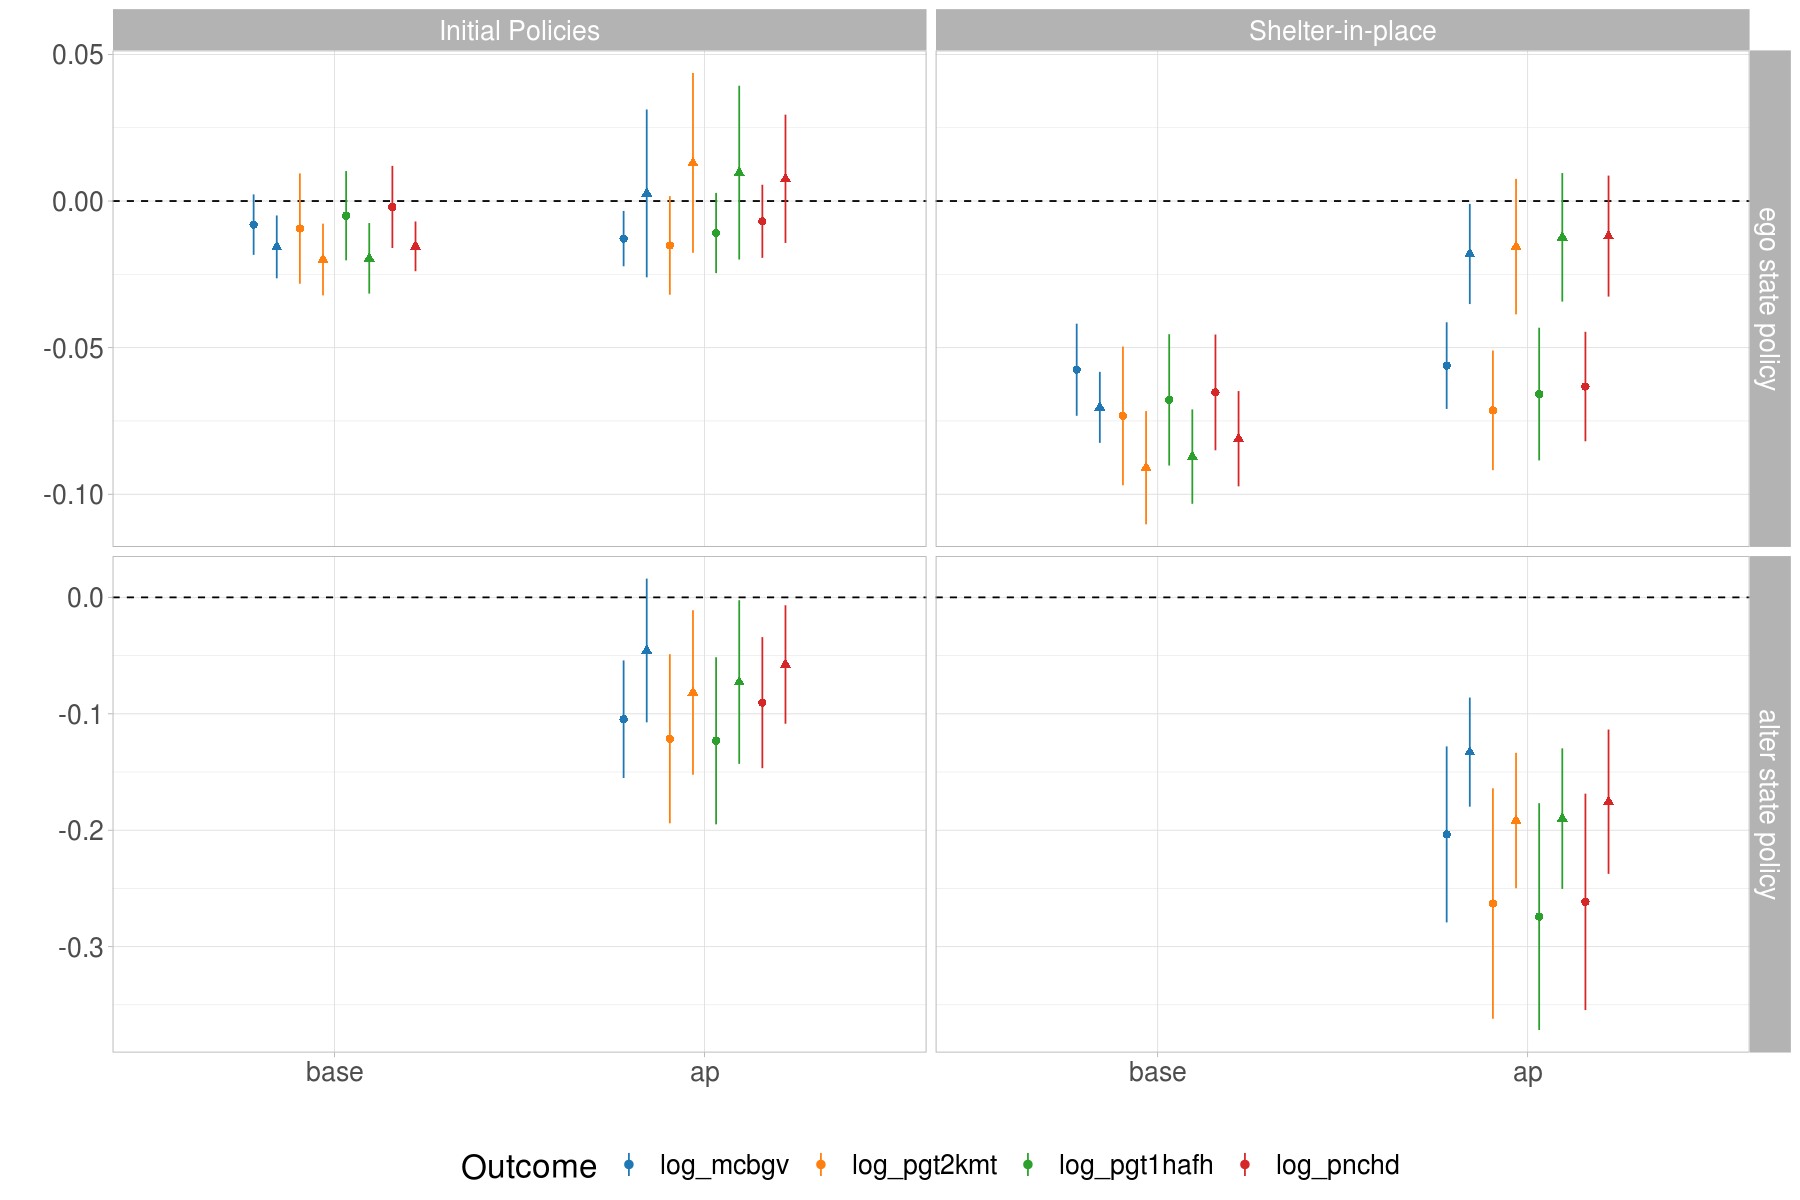

In [158]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'ego state policy',
        'b'     = 'alter state policy')

coefs %>%
    mutate(dv   = str_sub(dv, 1, -3),
           var  = str_sub(var, 1, -3),
           type = ifelse(str_detect(var, 'p[12]alt'), 'cp', 'sp'),
           type = factor(type, levels = c('sp', 'cp')),
           var  = str_replace(var, 'p1alt', 'p1sdp'),
           var  = str_replace(var, 'p2alt', 'p2shp')) %>%
    mutate(vtype = ifelse(str_detect(var, '(st)?alter'), 'b', 'a'),
           var   = str_replace(var, '(st)?alter_', ''),
           model = factor(model, levels = c('base', 'ap')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd', 'btvrc', 'log_rnstu'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv, shape = type)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    scale_shape(guide = 'none') + 
    scale_color_d3() +
    labs(color = "Outcome", shape = '') +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom')

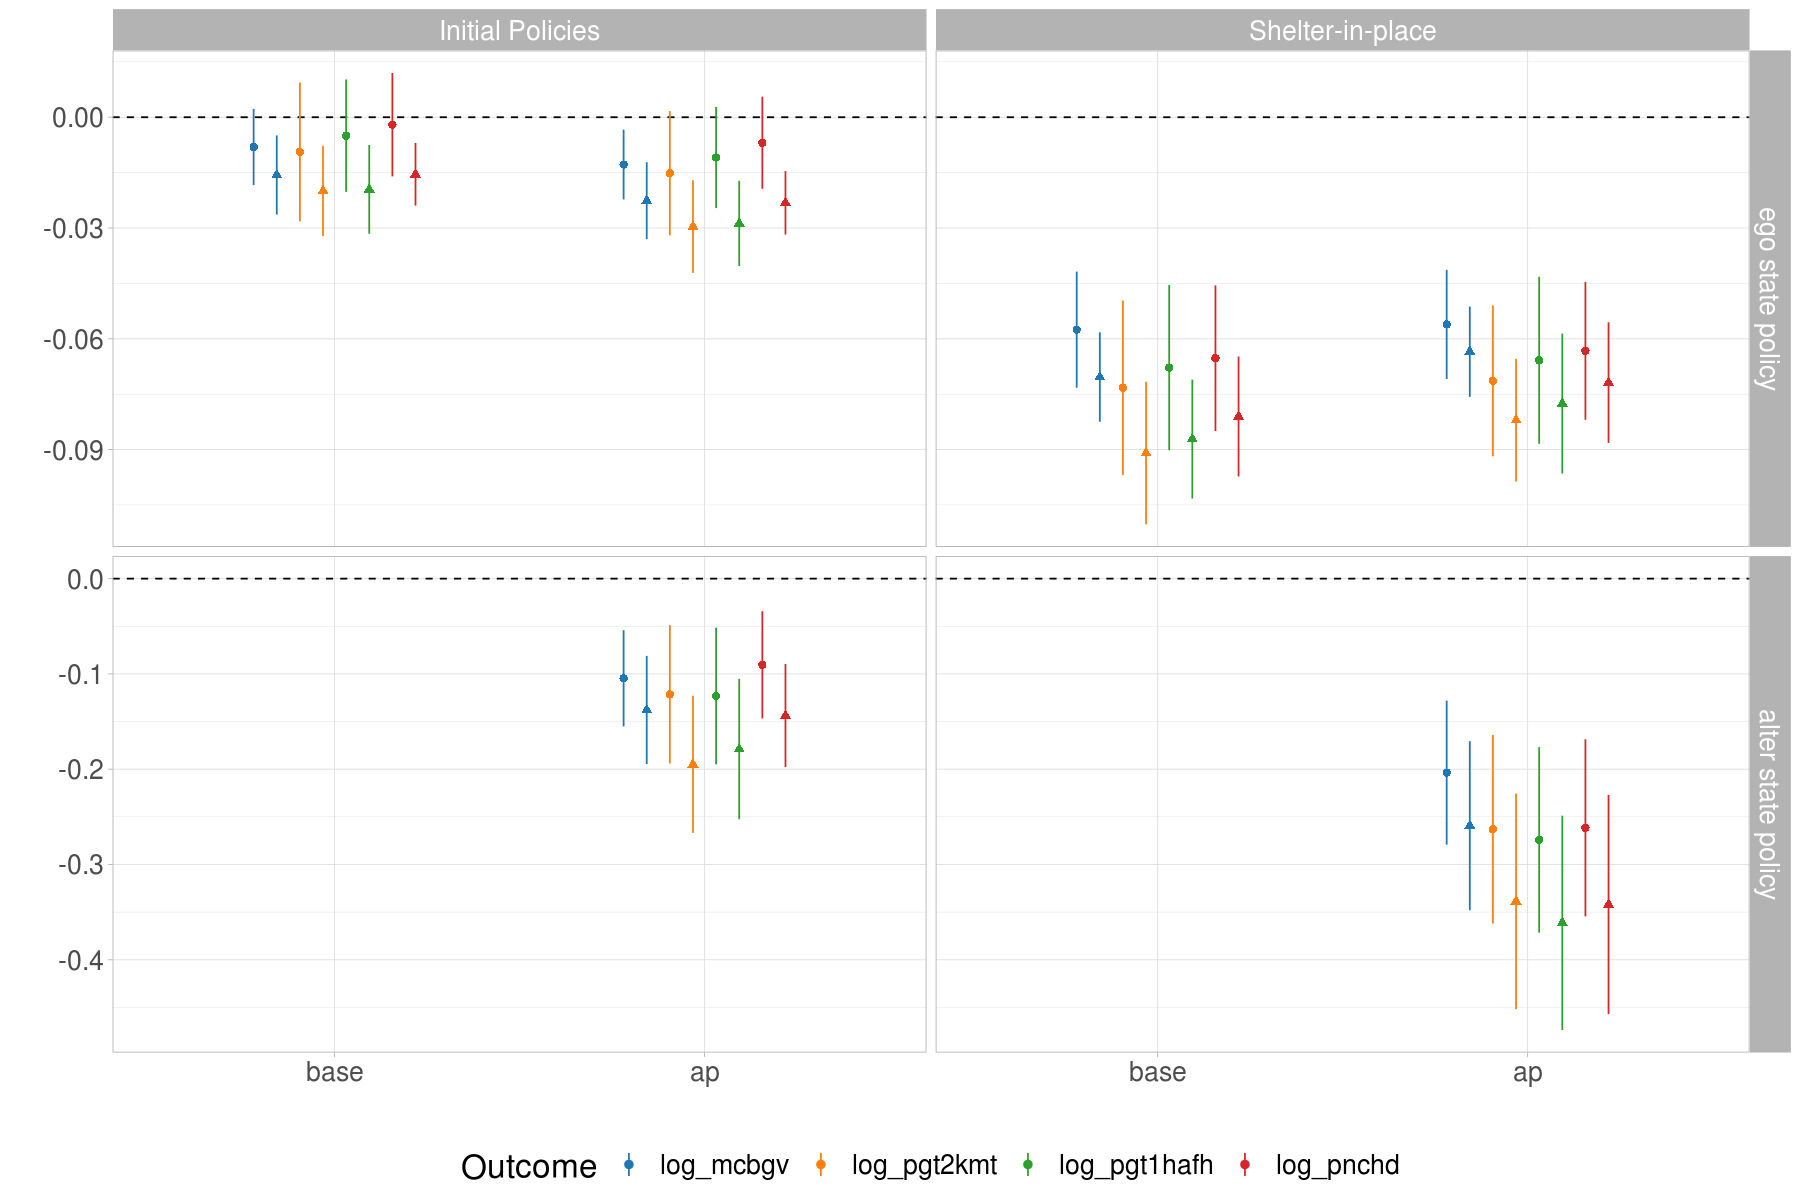

In [174]:
options(repr.plot.width=15, repr.plot.height=10)
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening",
        'a'     = 'ego state policy',
        'b'     = 'alter state policy')

coefs %>%
    mutate(dv   = str_sub(dv, 1, -3),
           var  = str_sub(var, 1, -3),
           type = ifelse(str_detect(var, 'p[12]alt'), 'cp', 'sp'),
           type = factor(type, levels = c('sp', 'cp')),
           var  = str_replace(var, 'p1alt', 'p1sdp'),
           var  = str_replace(var, 'p2alt', 'p2shp')) %>%
    mutate(vtype = ifelse(str_detect(var, '(st)?alter'), 'b', 'a'),
           var   = str_replace(var, '(st)?alter_', ''),
           model = factor(model, levels = c('base', 'ap')),
           dv = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd', 'btvrc', 'log_rnstu'))) %>%
    ggplot(aes(x = model, y = estimate, color = dv, shape = type)) +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(width = .5), size = 2) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se, ymax = estimate + 1.98 * se), 
                   position = position_dodge(width = .5), size = .5) +
    facet_grid(vtype~var, scales = 'free_y', labeller = as_labeller(pn)) +
    xlab('') + 
    ylab('') +
    scale_shape(guide = 'none') + 
    scale_color_d3() +
    labs(color = "Outcome", shape = '') +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom')

In [140]:
df %>%
    filter(p1alt != p1sdp)

key,date,mcbgv,pnchd,pgt1hafh,ppthlt75,pgt2kmt,dmcbgv,dpnchd,dpgt1hafh,⋯,log_alter_pgt1hafh,log_alter_ppthlt75,log_alter_pgt2kmt,p1date,p2date,p1alt,p2alt,stalter_p1alt,stalter_p2alt,fold
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
09001,2020-03-09,2.215660,0.8160597,0.6748942,0.6300147,0.6418352,0.03170040,0.1484141,0.12615349,⋯,-0.4320772,-0.4952216,-0.4898047,2020-03-16,2020-03-23,0,0,0,0,3
09003,2020-03-09,2.131473,0.7854467,0.6402711,0.6201271,0.5965311,0.12585229,0.1654587,0.13996935,⋯,-0.4275631,-0.4842263,-0.4701219,2020-03-16,2020-03-23,0,0,0,0,2
09005,2020-03-09,2.104100,0.8164000,0.6715000,0.6670000,0.6827000,0.07606825,0.1822194,0.15698176,⋯,-0.4286126,-0.4830549,-0.4751755,2020-03-16,2020-03-23,0,0,0,0,1
09007,2020-03-09,2.182612,0.8101887,0.6802662,0.6493946,0.6429584,0.04755778,0.1456726,0.13596510,⋯,-0.4310127,-0.4811057,-0.4776040,2020-03-16,2020-03-23,0,0,0,0,3
09009,2020-03-09,2.183596,0.7940922,0.6565535,0.6324927,0.6144786,0.13986857,0.1695459,0.14916966,⋯,-0.4286290,-0.4893861,-0.4735860,2020-03-16,2020-03-23,0,0,0,0,1
09011,2020-03-09,2.054027,0.7961191,0.6445375,0.6297847,0.6458666,0.13796939,0.1879521,0.16274442,⋯,-0.4259032,-0.4816209,-0.4644775,2020-03-16,2020-03-23,0,0,0,0,1
09013,2020-03-09,2.025872,0.8235096,0.6887514,0.6550056,0.6230596,0.02307684,0.1948849,0.17949323,⋯,-0.4316163,-0.4793092,-0.4756431,2020-03-16,2020-03-23,0,0,0,0,1
09015,2020-03-09,2.083345,0.8148351,0.6772957,0.6574518,0.6681265,0.12836975,0.1953243,0.18118679,⋯,-0.4308032,-0.4759173,-0.4662491,2020-03-16,2020-03-23,0,0,0,0,1
09001,2020-03-10,2.273105,0.8058144,0.6769771,0.6029374,0.6229695,0.47381641,0.2112059,0.21306870,⋯,-0.4250005,-0.5271458,-0.5022666,2020-03-16,2020-03-23,0,0,0,0,3
